In [139]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error as MSE

pd.options.display.float_format = '{:,.2f}'.format

In [214]:
country_list = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
country_list = country_list[["name", "alpha-3", "region", "sub-region"]]
country_list[country_list["name"].str.startswith("U")]

,name,alpha-3,region,sub-region
231,Uganda,UGA,Africa,Sub-Saharan Africa
232,Ukraine,UKR,Europe,Eastern Europe
233,United Arab Emirates,ARE,Asia,Western Asia
234,United Kingdom of Great Britain and Northern I...,GBR,Europe,Northern Europe
235,United States of America,USA,Americas,Northern America
236,United States Minor Outlying Islands,UMI,Oceania,Micronesia
237,Uruguay,URY,Americas,Latin America and the Caribbean
238,Uzbekistan,UZB,Asia,Central Asia


In [94]:
years_to_drop = ["{:d}".format(year) for year in range(1960, 2000)]

agricaltural_land_perc = pd.read_csv("Veri Setleri/API_AG.LND.AGRI.ZS_DS2_en_csv_v2_4669757/API_AG.LND.AGRI.ZS_DS2_en_csv_v2_4669757.csv", skiprows=4)
agricaltural_land_perc.drop([*(agricaltural_land_perc.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
agricaltural_land_perc = agricaltural_land_perc.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)
display(agricaltural_land_perc.head())

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2016,2017,2018,2019,2020,name,alpha-3,region,sub-region,_merge
0,Aruba,ABW,11.11,11.11,11.11,11.11,11.11,11.11,11.11,11.11,...,11.11,11.11,11.11,11.11,11.11,Aruba,ABW,Americas,Latin America and the Caribbean,both
1,Africa Eastern and Southern,AFE,44.61,44.75,44.89,45.22,44.97,45.15,45.35,45.51,...,43.90,44.05,44.17,44.19,44.25,NaN,NaN,NaN,NaN,left_only
2,Afghanistan,AFG,57.88,57.88,57.88,58.12,58.13,58.12,58.12,58.12,...,58.12,58.12,58.28,58.28,58.81,Afghanistan,AFG,Asia,Southern Asia,both
3,Africa Western and Central,AFW,37.03,37.36,37.45,37.72,37.65,38.34,38.33,38.48,...,39.64,39.68,39.71,39.72,39.74,NaN,NaN,NaN,NaN,left_only
4,Angola,AGO,37.67,38.11,38.56,39.00,39.45,39.89,40.34,40.79,...,44.79,45.24,45.68,45.68,45.68,Angola,AGO,Africa,Sub-Saharan Africa,both


In [95]:
forest_land_perc = pd.read_csv("Veri Setleri/API_AG.LND.FRST.ZS_DS2_en_csv_v2_4701080/API_AG.LND.FRST.ZS_DS2_en_csv_v2_4701080.csv", skiprows=4)
forest_land_perc.drop([*(forest_land_perc.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
forest_land_perc = forest_land_perc.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)
display(forest_land_perc.head())

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2016,2017,2018,2019,2020,name,alpha-3,region,sub-region,_merge
0,Aruba,ABW,2.33,2.33,2.33,2.33,2.33,2.33,2.33,2.33,...,2.33,2.33,2.33,2.33,2.33,Aruba,ABW,Americas,Latin America and the Caribbean,both
1,Africa Eastern and Southern,AFE,34.72,34.54,34.36,34.18,33.65,33.48,33.30,33.12,...,31.04,30.82,30.61,30.39,30.17,NaN,NaN,NaN,NaN,left_only
2,Afghanistan,AFG,1.85,1.85,1.85,1.85,1.85,1.85,1.85,1.85,...,1.85,1.85,1.85,1.85,1.85,Afghanistan,AFG,Asia,Southern Asia,both
3,Africa Western and Central,AFW,21.60,21.50,21.41,21.32,21.23,21.13,21.04,20.95,...,20.15,20.07,19.99,19.90,19.82,NaN,NaN,NaN,NaN,left_only
4,Angola,AGO,62.33,61.89,61.44,61.00,60.55,60.11,59.66,59.21,...,55.21,54.76,54.32,53.87,53.43,Angola,AGO,Africa,Sub-Saharan Africa,both


In [96]:
electric_access_perc = pd.read_csv("Veri Setleri/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_4695288/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_4695288.csv", skiprows=4)
electric_access_perc.drop([*(electric_access_perc.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
electric_access_perc = electric_access_perc.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)
display(electric_access_perc.head())

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2016,2017,2018,2019,2020,name,alpha-3,region,sub-region,_merge
0,Aruba,ABW,91.66,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,Aruba,ABW,Americas,Latin America and the Caribbean,both
1,Africa Eastern and Southern,AFE,19.81,19.90,21.53,22.47,23.78,23.49,24.76,26.77,...,38.88,40.26,43.06,44.27,45.80,NaN,NaN,NaN,NaN,left_only
2,Afghanistan,AFG,1.61,4.07,9.41,14.74,20.06,25.39,30.72,36.05,...,97.70,97.70,96.62,97.70,97.70,Afghanistan,AFG,Asia,Southern Asia,both
3,Africa Western and Central,AFW,34.15,35.27,35.76,39.88,37.55,37.85,39.84,40.79,...,50.95,48.86,51.26,51.29,52.11,NaN,NaN,NaN,NaN,left_only
4,Angola,AGO,24.21,20.00,26.35,27.41,28.47,29.53,30.59,37.50,...,41.81,43.01,45.29,45.64,46.89,Angola,AGO,Africa,Sub-Saharan Africa,both


In [98]:
co2_emission_kt = pd.read_csv("Veri Setleri/API_EN.ATM.CO2E.KT_DS2_en_csv_v2_4701269/API_EN.ATM.CO2E.KT_DS2_en_csv_v2_4701269.csv", skiprows=4)
co2_emission_kt.drop([*(co2_emission_kt.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
co2_emission_kt = co2_emission_kt.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)
display(co2_emission_kt.head())

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2016,2017,2018,2019,2020,name,alpha-3,region,sub-region,_merge
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aruba,ABW,Americas,Latin America and the Caribbean,both
1,Africa Eastern and Southern,AFE,"355,920.00","393,150.00","404,210.01","426,380.00","457,599.99","458,459.99","465,440.01","486,180.00",...,"578,510.02","587,509.99","590,040.01","603,030.02",NaN,NaN,NaN,NaN,NaN,left_only
2,Afghanistan,AFG,760.00,730.00,"1,030.00","1,220.00","1,030.00","1,550.00","1,760.00","1,770.00",...,"5,300.00","4,780.00","6,070.00","6,080.00",NaN,Afghanistan,AFG,Asia,Southern Asia,both
3,Africa Western and Central,AFW,"141,740.00","149,460.00","141,660.00","150,990.00","150,990.00","155,280.00","148,880.00","142,610.00",...,"206,030.00","204,740.00","211,720.00","220,740.00",NaN,NaN,NaN,NaN,NaN,left_only
4,Angola,AGO,"16,200.00","15,960.00","15,690.00","16,760.00","17,450.00","15,810.00","16,560.00","16,970.00",...,"29,760.00","24,250.00","23,960.00","25,210.00",NaN,Angola,AGO,Africa,Sub-Saharan Africa,both


In [99]:
agri_forest_value_added = pd.read_csv("Veri Setleri/API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_4677103/API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_4677103.csv", skiprows=4)
agri_forest_value_added.drop([*(agri_forest_value_added.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
agri_forest_value_added = agri_forest_value_added.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)
display(agri_forest_value_added.head())

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2016,2017,2018,2019,2020,name,alpha-3,region,sub-region,_merge
0,Aruba,ABW,0.41,0.41,0.40,0.40,0.39,0.38,0.39,0.40,...,NaN,NaN,NaN,NaN,NaN,Aruba,ABW,Americas,Latin America and the Caribbean,both
1,Africa Eastern and Southern,AFE,12.58,12.54,12.77,11.00,9.85,9.78,10.02,10.97,...,13.72,13.44,12.09,12.71,14.66,NaN,NaN,NaN,NaN,left_only
2,Afghanistan,AFG,NaN,NaN,38.63,37.42,29.72,31.11,28.64,30.11,...,25.74,26.42,22.04,25.77,26.82,Afghanistan,AFG,Asia,Southern Asia,both
3,Africa Western and Central,AFW,21.22,23.28,30.22,28.13,24.13,24.21,23.09,22.81,...,21.01,20.81,20.93,21.28,22.97,NaN,NaN,NaN,NaN,left_only
4,Angola,AGO,5.66,8.16,5.84,6.20,6.25,5.06,5.19,5.24,...,9.83,10.02,8.61,7.88,9.11,Angola,AGO,Africa,Sub-Saharan Africa,both


In [100]:
industry_value_added = pd.read_csv("Veri Setleri/API_NV.IND.TOTL.ZS_DS2_en_csv_v2_4695695/API_NV.IND.TOTL.ZS_DS2_en_csv_v2_4695695.csv", skiprows=4)
industry_value_added.drop([*(industry_value_added.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
industry_value_added = industry_value_added.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)
display(industry_value_added.head())

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2016,2017,2018,2019,2020,name,alpha-3,region,sub-region,_merge
0,Aruba,ABW,15.83,16.11,15.12,16.60,17.39,18.28,19.21,18.54,...,NaN,NaN,NaN,NaN,NaN,Aruba,ABW,Americas,Latin America and the Caribbean,both
1,Africa Eastern and Southern,AFE,26.89,26.84,27.46,26.70,27.05,28.01,28.03,29.20,...,24.46,24.53,26.53,26.40,25.71,NaN,NaN,NaN,NaN,left_only
2,Afghanistan,AFG,NaN,NaN,23.81,22.71,26.23,26.81,28.21,26.88,...,10.47,10.05,13.39,14.06,14.03,Afghanistan,AFG,Asia,Southern Asia,both
3,Africa Western and Central,AFW,32.11,28.11,25.31,27.28,29.35,28.92,27.52,26.36,...,21.03,24.13,26.44,27.14,27.36,NaN,NaN,NaN,NaN,left_only
4,Angola,AGO,72.12,64.88,56.08,53.12,54.63,60.40,58.11,61.88,...,42.64,42.17,47.93,49.76,45.73,Angola,AGO,Africa,Sub-Saharan Africa,both


In [101]:
gdp_per_capita = pd.read_csv("Veri Setleri/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4701206/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4701206.csv", skiprows=4)
gdp_per_capita.drop([*(gdp_per_capita.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
gdp_per_capita = gdp_per_capita.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)
display(gdp_per_capita.head())

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2016,2017,2018,2019,2020,name,alpha-3,region,sub-region,_merge
0,Aruba,ABW,"20,614.80","20,417.78","20,654.49","21,070.07","22,834.28","23,591.16","24,495.02","26,452.23",...,"28,453.72","29,348.42","30,253.71","31,135.88","23,384.30",Aruba,ABW,Americas,Latin America and the Caribbean,both
1,Africa Eastern and Southern,AFE,713.18,633.55,631.81,819.67,993.67,"1,129.70","1,236.99","1,382.74",...,"1,446.53","1,629.40","1,541.03","1,511.31","1,360.88",NaN,NaN,NaN,NaN,left_only
2,Afghanistan,AFG,NaN,NaN,179.43,190.68,211.38,242.03,263.73,359.69,...,512.01,516.68,485.67,494.18,516.75,Afghanistan,AFG,Asia,Southern Asia,both
3,Africa Western and Central,AFW,525.46,539.34,627.79,706.96,854.51,"1,016.49","1,252.62","1,430.84",...,"1,673.84","1,613.49","1,704.14","1,777.85","1,709.76",NaN,NaN,NaN,NaN,left_only
4,Angola,AGO,556.84,527.33,872.49,982.96,"1,255.56","1,902.42","2,599.57","3,122.00",...,"1,728.02","2,313.22","2,524.94","2,177.80","1,631.43",Angola,AGO,Africa,Sub-Saharan Africa,both


In [247]:
total_pop = pd.read_csv("Veri Setleri/API_SP.POP.TOTL_DS2_en_csv_v2_4701113/API_SP.POP.TOTL_DS2_en_csv_v2_4701113.csv", skiprows=4)
total_pop.drop([*(total_pop.columns[-2:]), "Indicator Name", "Indicator Code", *years_to_drop], axis=1, inplace=True)
total_pop = total_pop.merge(country_list, left_on="Country Code", right_on="alpha-3", how="left", indicator=True)
display(total_pop.head())

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2016,2017,2018,2019,2020,name,alpha-3,region,sub-region,_merge
0,Aruba,ABW,"90,866.00","92,892.00","94,992.00","97,016.00","98,744.00","100,028.00","100,830.00","101,226.00",...,"104,865.00","105,361.00","105,846.00","106,310.00","106,766.00",Aruba,ABW,Americas,Latin America and the Caribbean,both
1,Africa Eastern and Southern,AFE,"398,113,044.00","408,522,129.00","419,223,717.00","430,246,635.00","441,630,149.00","453,404,076.00","465,581,372.00","478,166,911.00",...,"609,978,946.00","626,392,880.00","643,090,131.00","660,046,272.00","677,243,299.00",NaN,NaN,NaN,NaN,left_only
2,Afghanistan,AFG,"20,779,957.00","21,606,992.00","22,600,774.00","23,680,871.00","24,726,689.00","25,654,274.00","26,433,058.00","27,100,542.00",...,"35,383,028.00","36,296,111.00","37,171,922.00","38,041,757.00","38,928,341.00",Afghanistan,AFG,Asia,Southern Asia,both
3,Africa Western and Central,AFW,"267,214,544.00","274,433,894.00","281,842,480.00","289,469,530.00","297,353,098.00","305,520,588.00","313,985,474.00","322,741,656.00",...,"412,551,299.00","423,769,930.00","435,229,381.00","446,911,598.00","458,803,476.00",NaN,NaN,NaN,NaN,left_only
4,Angola,AGO,"16,395,477.00","16,945,753.00","17,519,418.00","18,121,477.00","18,758,138.00","19,433,604.00","20,149,905.00","20,905,360.00",...,"28,842,482.00","29,816,769.00","30,809,787.00","31,825,299.00","32,866,268.00",Angola,AGO,Africa,Sub-Saharan Africa,both


In [103]:
dataframe_list = [agricaltural_land_perc, forest_land_perc, electric_access_perc, co2_emission_kt, agri_forest_value_added, industry_value_added, gdp_per_capita, total_pop]
dataframe_names = ["agricaltural_land_perc", "forest_land_perc", "electric_access_perc", "co2_emission_kt", "agri_forest_value_added", "industry_value_added", "gdp_per_capita", "total_pop"]
all_data_df = pd.DataFrame(columns=['alpha-3', 'region', 'agricaltural_land_perc', 'forest_land_perc',
       'electric_access_perc', 'co2_emission_kt', 'agri_forest_value_added',
       'industry_value_added', 'gdp_per_capita', 'total_pop', "data_year"])

for year in ["{:d}".format(year) for year in range(2000, 2021)]:
    selected_columns = ["Country Code", year]
    single_year_values = country_list[["alpha-3", "region"]]
    for dataframe, name in zip(dataframe_list, dataframe_names):
        single_year_values = single_year_values.merge(dataframe[selected_columns], how="inner", left_on="alpha-3", right_on="Country Code")
        single_year_values.drop("Country Code", axis=1, inplace=True)
        single_year_values.rename({year: name}, inplace=True, axis=1)
        single_year_values["data_year"] = int(year)
    all_data_df = pd.concat([all_data_df, single_year_values], axis=0)

all_data_df["transformed_co2_emission_kt"] = np.log(all_data_df.co2_emission_kt)
display(all_data_df.describe())

,agricaltural_land_perc,forest_land_perc,electric_access_perc,co2_emission_kt,agri_forest_value_added,industry_value_added,gdp_per_capita,total_pop,transformed_co2_emission_kt
count,"4,377.00","4,416.00","4,470.00","3,818.00","4,001.00","3,990.00","4,320.00","4,506.00","3,818.00"
mean,37.52,32.51,80.67,"154,294.76",11.43,26.04,"15,032.87","32,176,575.11",9.23
std,22.08,24.60,29.44,"721,437.83",11.49,12.54,"23,311.49","128,338,255.79",2.53
min,0.45,0.00,0.64,10.00,0.01,3.15,111.93,"9,392.00",2.30
25%,19.06,11.02,67.27,"1,722.50",2.40,17.98,"1,446.22","707,492.25",7.45
50%,38.48,30.92,99.10,"9,790.00",7.51,24.03,"4,927.66","5,826,667.50",9.19
75%,54.71,51.60,100.00,"60,675.00",17.45,30.85,"19,282.49","20,418,374.00",11.01
max,85.64,98.34,100.00,"10,707,219.73",79.04,86.67,"189,487.15","1,411,100,000.00",16.19


In [104]:
all_data_df.groupby("region")["co2_emission_kt"].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Africa,"1,080.00","20,717.39","62,132.62",50.00,657.50,"2,705.00","8,017.50","447,929.99"
Americas,700.00,"211,419.74","890,018.49",120.00,"1,655.00","7,650.00","39,727.50","5,775,810.00"
Asia,938.00,"314,724.73","1,182,655.71",170.00,"8,682.50","43,000.00","158,210.00","10,707,219.73"
Europe,820.00,"140,488.27","282,626.30",140.00,"11,227.50","44,780.00","101,860.00","1,703,589.97"
Oceania,280.00,"29,702.21","96,536.37",10.00,100.00,180.00,"1,185.00","395,290.01"


[]

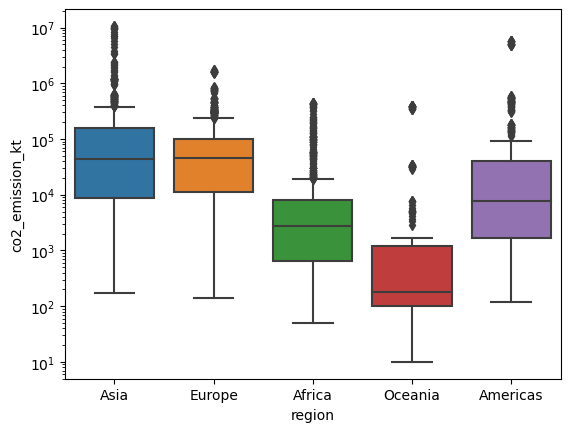

In [240]:
ax = sns.boxplot(data=all_data_df, x="region", y="co2_emission_kt")
ax.semilogy()

In [237]:
all_data_df[all_data_df["region"] == "Americas"].groupby("alpha-3")["co2_emission_kt"].agg(np.mean).sort_values(ascending=False)

alpha-3
USA   5,329,538.53
CAN     547,644.50
MEX     444,619.50
BRA     392,988.50
ARG     160,462.00
VEN     149,444.00
CHL      69,111.50
COL      66,926.00
PER      41,909.50
ECU      33,437.00
CUB      27,146.50
DOM      21,237.50
TTO      18,280.50
BOL      15,152.00
GTM      12,992.50
JAM       8,956.50
PAN       8,589.50
HND       8,265.00
CRI       7,043.50
SLV       6,711.50
URY       6,323.50
PRY       5,187.00
NIC       4,650.50
BHS       2,588.50
HTI       2,385.00
SUR       1,917.50
GUY       1,898.00
BRB       1,590.00
BLZ         600.00
LCA         545.00
ATG         513.00
GRD         306.00
VCT         280.50
KNA         264.50
DMA         186.00
ABW            NaN
BMU            NaN
CUW            NaN
CYM            NaN
GRL            NaN
MAF            NaN
PRI            NaN
SXM            NaN
TCA            NaN
VGB            NaN
VIR            NaN
Name: co2_emission_kt, dtype: float64

,alpha-3,region,agricaltural_land_perc,forest_land_perc,electric_access_perc,co2_emission_kt,agri_forest_value_added,industry_value_added,gdp_per_capita,total_pop,data_year,transformed_co2_emission_kt
0,AFG,Asia,57.88,1.85,1.61,760.00,NaN,NaN,NaN,"20,779,957.00",2000,6.63
1,ALB,Europe,41.75,28.08,100.00,"3,170.00",24.52,19.40,"1,126.68","3,089,027.00",2000,8.06
2,DZA,Africa,16.80,0.66,98.97,"80,050.00",8.40,46.25,"1,765.03","31,042,238.00",2000,11.29
3,ASM,Oceania,29.85,88.65,NaN,NaN,NaN,NaN,NaN,"57,816.00",2000,NaN
4,AND,Europe,48.94,34.04,100.00,520.00,NaN,NaN,"21,854.25","65,390.00",2000,6.25


Text(0, 0.5, 'CO2 Emisyonu (kton)')

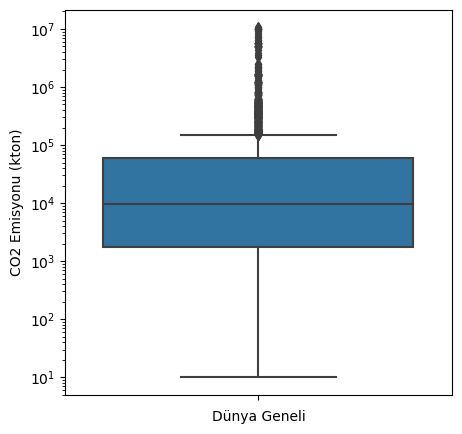

In [105]:
display(all_data_df.head())
ax = sns.boxplot(data=all_data_df.dropna(subset=["co2_emission_kt"]), y="co2_emission_kt")
ax.semilogy()
ax.get_figure().set_size_inches(5,5)
ax.set_xlabel("Dünya Geneli")
ax.set_ylabel("CO2 Emisyonu (kton)")

In [192]:
regions = all_data_df.region.unique()
emission_by_country_2019 = {}

for region in regions:
    emissions_mask = np.logical_and(all_data_df["data_year"] == 2019, all_data_df["region"].isin([region]))
    emission_by_country_2019[region] = all_data_df[emissions_mask]["co2_emission_kt"].dropna()

f_stat, p_value = stats.f_oneway(emission_by_country_2019["Asia"], emission_by_country_2019["Europe"], emission_by_country_2019["Oceania"], emission_by_country_2019["Africa"], emission_by_country_2019["Americas"])
display("CO2 emisyon dağılımı arasında kıtalara bağlı bir farklılık olup olmadığı üzere yapılan ANOVA analizinin sonucu olarak F değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(f_stat, p_value))


#‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Oceania"], emission_by_country_2019["Asia"], alternative="less", equal_var=False)
display("Asya ve Avrupa CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

'CO2 emisyon dağılımı arasında kıtalara bağlı bir farklılık olup olmadığı üzere yapılan ANOVA analizinin sonucu olarak F değeri: 1.471 ve p değeri: 0.213 olarak elde edilmiştir.'

'Asya ve Avrupa CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: -1.682 ve p değeri: 0.050 olarak elde edilmiştir.'

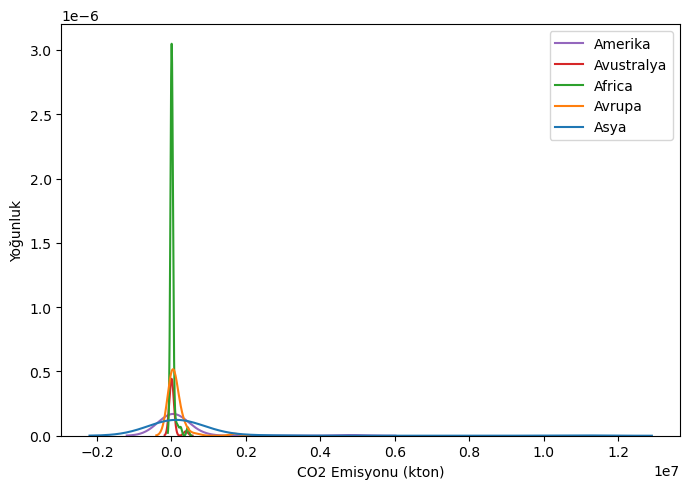

In [107]:
masking = all_data_df["data_year"] == 2019
ax = sns.kdeplot(data=all_data_df[masking], x="co2_emission_kt", hue="region", legend=False)
plt.legend(labels=["Amerika", "Avustralya", "Africa", "Avrupa", "Asya"])
ax.set_ylabel("Yoğunluk")
ax.set_xlabel("CO2 Emisyonu (kton)")
ax.get_figure().set_size_inches(7,5)
ax.get_figure().tight_layout()

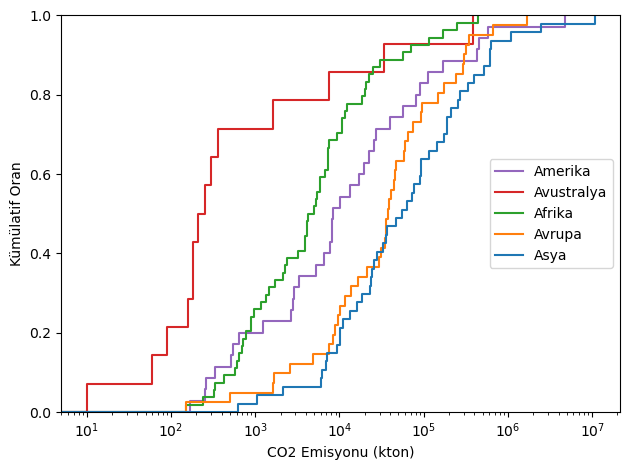

In [108]:
axes = sns.ecdfplot(data=all_data_df[all_data_df["data_year"] == 2019], x="co2_emission_kt", hue="region", legend=False)
axes.semilogx()
axes.set_xlabel("CO2 Emisyonu (kton)")
axes.set_ylabel("Kümülatif Oran")
axes.legend(labels=np.flip(["Asya", "Avrupa", "Afrika", "Avustralya", "Amerika"]), loc="center right")
axes.get_figure().tight_layout()

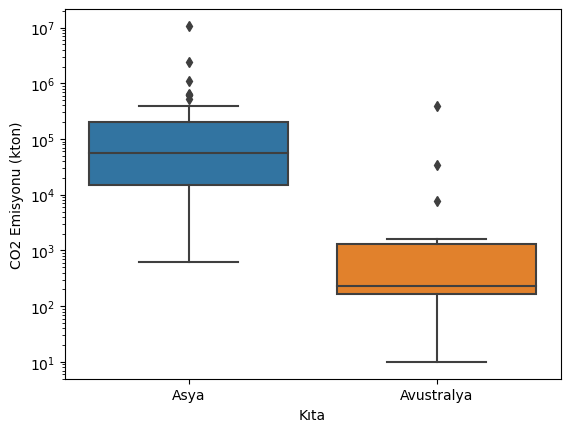

In [109]:
masking = np.logical_and(all_data_df["data_year"] == 2019, all_data_df["region"].isin(["Oceania", "Asia"]))
ax = sns.boxplot(data=all_data_df[masking], y="co2_emission_kt", x="region")
ax.semilogy()
ax.set_xlabel("Kıta")
ax.set_ylabel("CO2 Emisyonu (kton)")
ax.set_xticks(labels=["Asya", "Avustralya"], ticks=[0, 1])


In [187]:
regions = all_data_df.region.unique()
emission_by_country_2019 = {}

for region in regions:
    emissions_mask = np.logical_and(all_data_df["data_year"] == 2019, all_data_df["region"].isin([region]))
    emission_by_country_2019[region] = all_data_df[emissions_mask]["transformed_co2_emission_kt"].dropna()

f_stat, p_value = stats.f_oneway(emission_by_country_2019["Asia"], emission_by_country_2019["Europe"], emission_by_country_2019["Oceania"], emission_by_country_2019["Africa"], emission_by_country_2019["Americas"])
display("CO2 emisyon dağılımı arasında kıtalara bağlı bir farklılık olup olmadığı üzere yapılan ANOVA analizinin sonucu olarak F değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(f_stat, p_value))


#‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
t_stat, p_value = stats.ttest_ind(emission_by_country_2019["Oceania"], emission_by_country_2019["Asia"], alternative="less", equal_var=False)
display("Asya ve Avustralya CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: {:.3f} ve p değeri: {:.3f} olarak elde edilmiştir.".format(t_stat, p_value))

'CO2 emisyon dağılımı arasında kıtalara bağlı bir farklılık olup olmadığı üzere yapılan ANOVA analizinin sonucu olarak F değeri: 19.413 ve p değeri: 0.000 olarak elde edilmiştir.'

'Asya ve Avustralya CO2 emisyon dağılımı arasında bir farklılık olup olmadığı üzere yapılan ttest analizinin sonucu olarak t değeri: -5.860 ve p değeri: 0.000 olarak elde edilmiştir.'

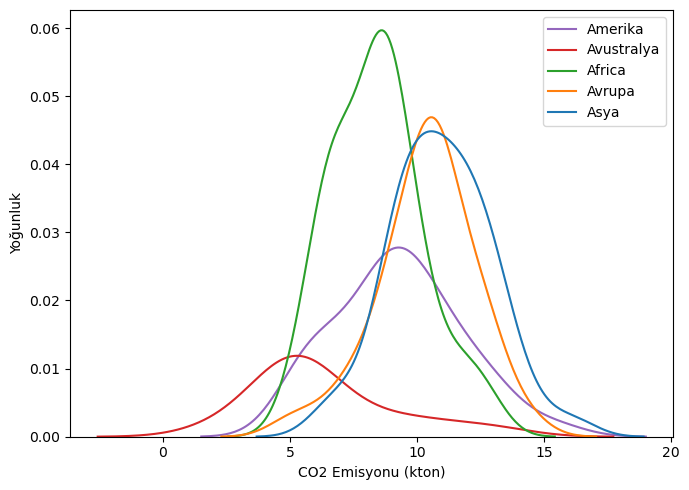

In [111]:
masking = all_data_df["data_year"] == 2019
ax = sns.kdeplot(data=all_data_df[masking], x="transformed_co2_emission_kt", hue="region", legend=False)
plt.legend(labels=["Amerika", "Avustralya", "Africa", "Avrupa", "Asya"])
ax.set_ylabel("Yoğunluk")
ax.set_xlabel("CO2 Emisyonu (kton)")
ax.get_figure().set_size_inches(7,5)
ax.get_figure().tight_layout()

In [186]:
region_by_year_emission = all_data_df[["region", "data_year", "co2_emission_kt"]]
years = region_by_year_emission.data_year.unique()
countries = region_by_year_emission.region.unique()
p_values = {}
t_stats = {}

for region in countries:
    p_value_list = []
    t_stat_list = []
    for year in years[:-2]:
        year_mask = region_by_year_emission.data_year == year
        next_year_mask = region_by_year_emission.data_year == year+1
        region_mask = region_by_year_emission.region == region
        
        #‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.
        t_stat, p_value = stats.ttest_ind(region_by_year_emission[np.logical_and(region_mask, year_mask)]["co2_emission_kt"].dropna(), 
                                                                   region_by_year_emission[np.logical_and(region_mask, next_year_mask)]["co2_emission_kt"].dropna(), 
                                                                       alternative="less", equal_var=False)
        p_value_list.append(p_value)
        t_stat_list.append(t_stat)
    p_values[region] = p_value_list
    t_stats[region] = t_stat_list

pd.DataFrame(p_values)

,Asia,Europe,Africa,Oceania,Americas
0,0.48,0.49,0.45,0.49,0.50
1,0.48,0.50,0.49,0.49,0.51
2,0.45,0.47,0.47,0.50,0.49
3,0.45,0.50,0.47,0.49,0.49
4,0.46,0.50,0.48,0.50,0.50
5,0.46,0.49,0.49,0.50,0.50
6,0.46,0.51,0.48,0.49,0.49
7,0.48,0.52,0.46,0.50,0.51
8,0.48,0.57,0.50,0.50,0.52
9,0.46,0.47,0.46,0.51,0.48


Text(0.5, 0, 'Yıl')

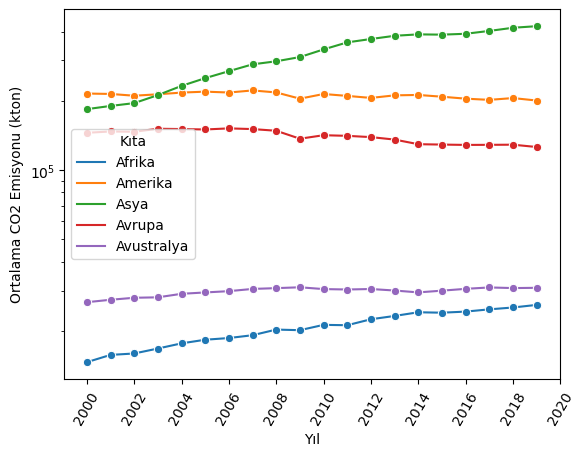

In [209]:
country_map = {
    "Europe": "Avrupa",
    "Oceania": "Avustralya",
    "Asia": "Asya",
    "Africa": "Afrika",
    "Americas": "Amerika"
}
region_by_year_emission = all_data_df.groupby(["region", "data_year"])["co2_emission_kt"].agg([np.sum, np.mean, np.std]).reset_index().replace({"region": country_map}).rename({"region": "Kıta"}, axis=1)

ax = sns.lineplot(data=region_by_year_emission, x="data_year", y="mean", hue="Kıta", legend=True, marker="o")
ax.semilogy()
ax.set_xticks(ticks=range(2000, 2021, 2))
ax.tick_params(axis="x", rotation=60)
ax.set_ylabel("Ortalama CO2 Emisyonu (kton)")
ax.set_xlabel("Yıl")

Text(0.5, 0, 'Yıl')

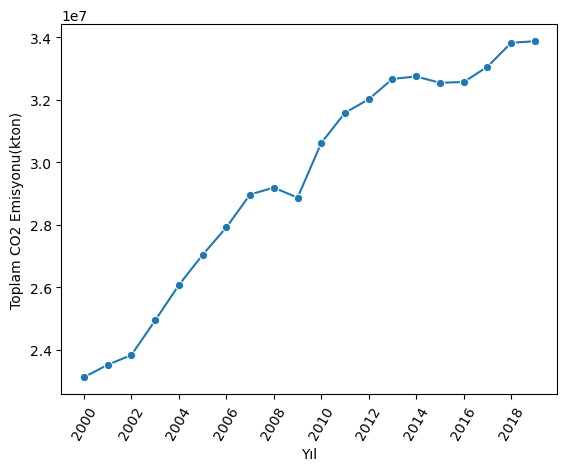

In [208]:
emisson_by_year = all_data_df.groupby(["data_year"])["co2_emission_kt"].agg([np.sum, np.mean, np.std]).drop(labels=[2020], axis=0)

ax = sns.lineplot(data=emisson_by_year, x="data_year", y="sum", marker="o")
ax.set_xticks(labels=range(2000, 2020, 2), ticks=range(2000, 2020, 2))
ax.tick_params(axis="x", rotation=60)

ax.set_ylabel("Toplam CO2 Emisyonu(kton)")
ax.set_xlabel("Yıl")

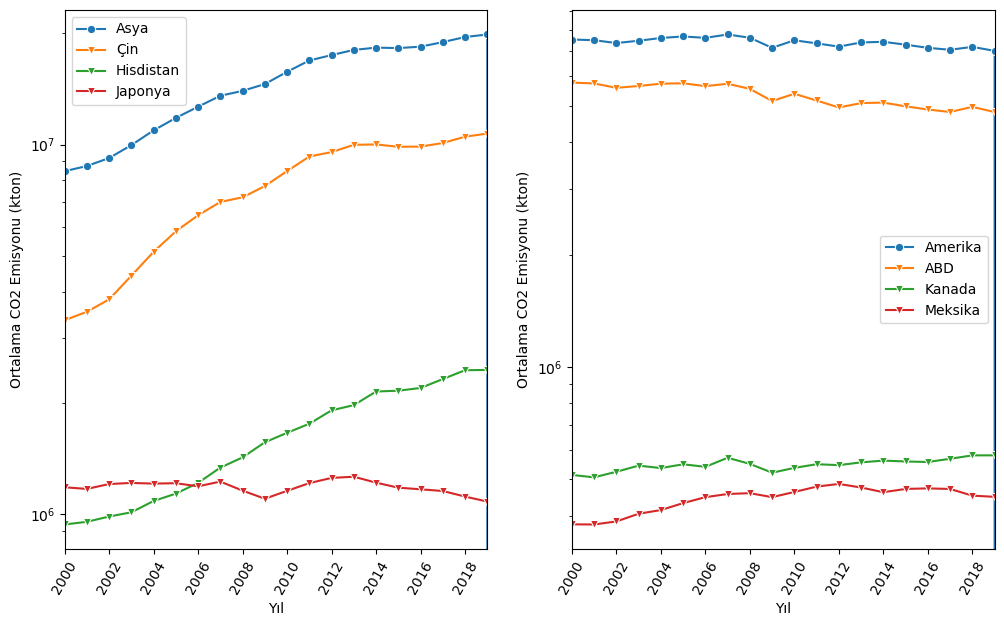

In [238]:
fig, ax = plt.subplots(ncols=2, nrows=1)

sns.lineplot(x=region_by_year_emission[region_by_year_emission.Kıta == "Asya"]["data_year"], y=region_by_year_emission[region_by_year_emission.Kıta == "Asya"]["sum"], label="Asya", marker="o", ax=ax[0])
sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "CHN"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "CHN"]["co2_emission_kt"].values, label="Çin", ax=ax[0], marker="v")
sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "IND"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "IND"]["co2_emission_kt"].values, label="Hisdistan", ax=ax[0], marker="v")
sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "JPN"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "JPN"]["co2_emission_kt"].values, label="Japonya", ax=ax[0], marker="v")

ax[0].legend()
ax[0].semilogy()
ax[0].set_xticks(ticks=range(2000, 2021, 2))
ax[0].set_xlim(2000, 2019)
ax[0].tick_params(axis="x", rotation=60)
ax[0].set_ylabel("Ortalama CO2 Emisyonu (kton)")
ax[0].set_xlabel("Yıl")

sns.lineplot(x=region_by_year_emission[region_by_year_emission.Kıta == "Amerika"]["data_year"], y=region_by_year_emission[region_by_year_emission.Kıta == "Amerika"]["sum"], label="Amerika", marker="o", ax=ax[1])
sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "USA"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "USA"]["co2_emission_kt"].values, label="ABD", ax=ax[1], marker="v")
sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "CAN"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "CAN"]["co2_emission_kt"].values, label="Kanada", ax=ax[1], marker="v")
sns.lineplot(x=all_data_df[all_data_df["alpha-3"] == "MEX"]["data_year"].values, y=all_data_df[all_data_df["alpha-3"] == "MEX"]["co2_emission_kt"].values, label="Meksika", ax=ax[1], marker="v")
ax[1].legend()
ax[1].semilogy()
ax[1].set_xticks(ticks=range(2000, 2021, 2))
ax[1].set_xlim(2000, 2019)
ax[1].tick_params(axis="x", rotation=60)
ax[1].set_ylabel("Ortalama CO2 Emisyonu (kton)")
ax[1].set_xlabel("Yıl")

fig.set_size_inches(12, 7)

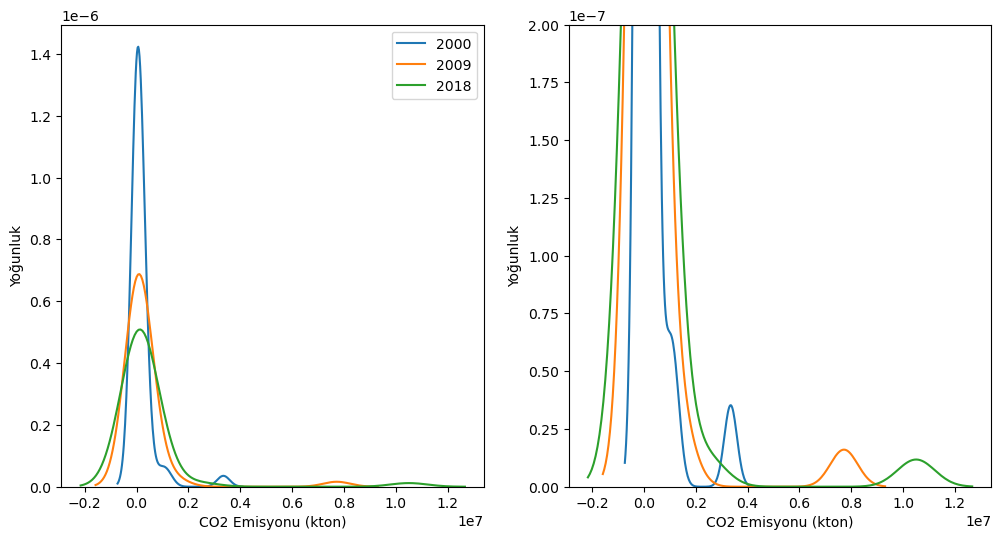

In [135]:
fig, ax = plt.subplots(nrows=1, ncols=2)

for year in years[:-2:9]:
    plotter_df = all_data_df[["region", "data_year", "co2_emission_kt"]] \
    [np.logical_and(all_data_df.region == "Asia", all_data_df.data_year == year)]

    sns.kdeplot(data=plotter_df, x="co2_emission_kt", label=year, ax=ax[0])
    sns.kdeplot(data=plotter_df, x="co2_emission_kt", label=year, ax=ax[1])

ax[0].set_xlabel("CO2 Emisyonu (kton)")
ax[1].set_xlabel("CO2 Emisyonu (kton)")
ax[0].set_ylabel("Yoğunluk")
ax[1].set_ylabel("Yoğunluk")

ax[0].legend()
ax[1].set_ylim(0, 0.2e-6)


fig.set_size_inches(12, 6)

/tmp/ipykernel_28373/1839307960.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(all_data_df.drop(labels=["transformed_co2_emission_kt"], axis=1).corr(), annot=True)


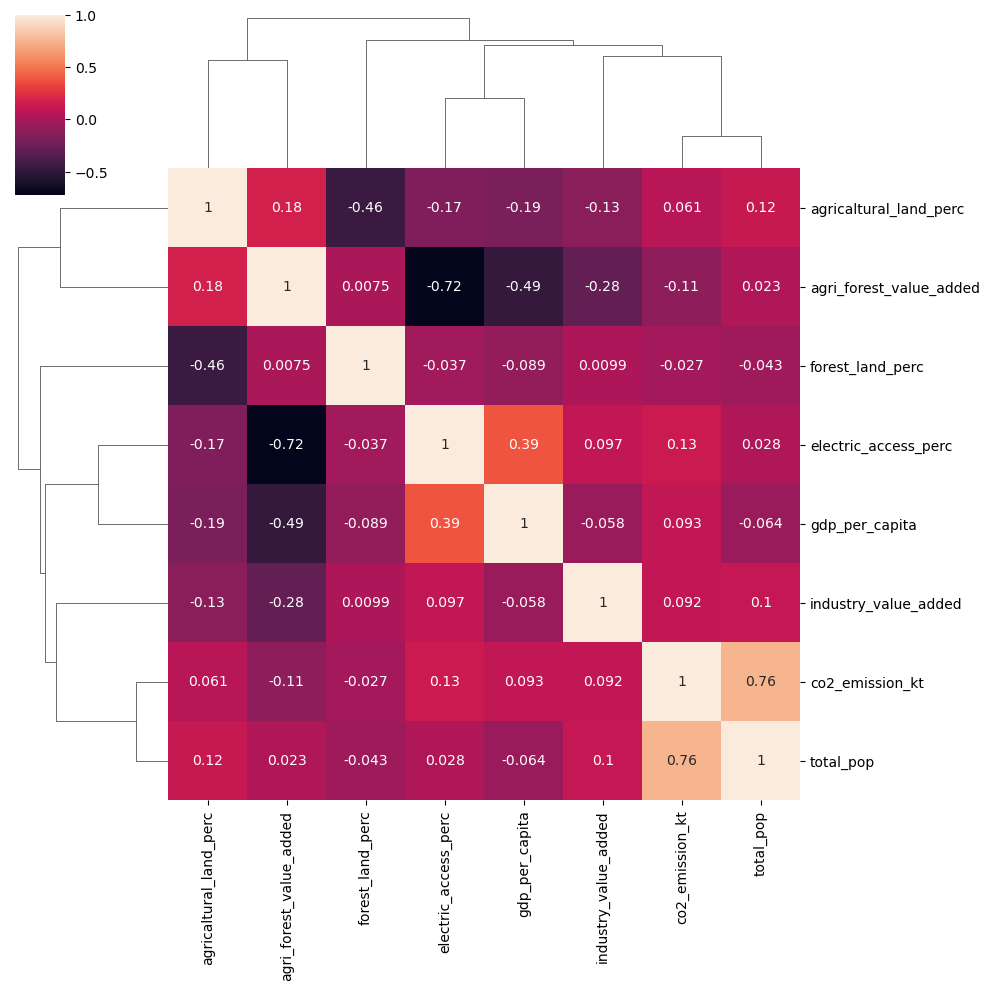

In [23]:
sns.clustermap(all_data_df.drop(labels=["transformed_co2_emission_kt"], axis=1).corr(), annot=True)

100%|██████████| 8/8 [00:00<00:00, 14.05it/s]


,agricaltural_land_perc,forest_land_perc,electric_access_perc,co2_emission_kt,agri_forest_value_added,industry_value_added,gdp_per_capita,total_pop
1,41.75,28.08,100.00,"3,170.00",24.52,19.40,"1,126.68","3,089,027.00"
2,16.80,0.66,98.97,"80,050.00",8.40,46.25,"1,765.03","31,042,238.00"
5,37.67,62.33,24.21,"16,200.00",5.66,72.12,556.84,"16,395,477.00"
6,20.45,21.48,97.69,330.00,1.60,13.89,"10,872.29","76,007.00"
7,46.96,12.20,95.78,"132,270.00",4.68,25.99,"7,708.10","36,870,796.00"


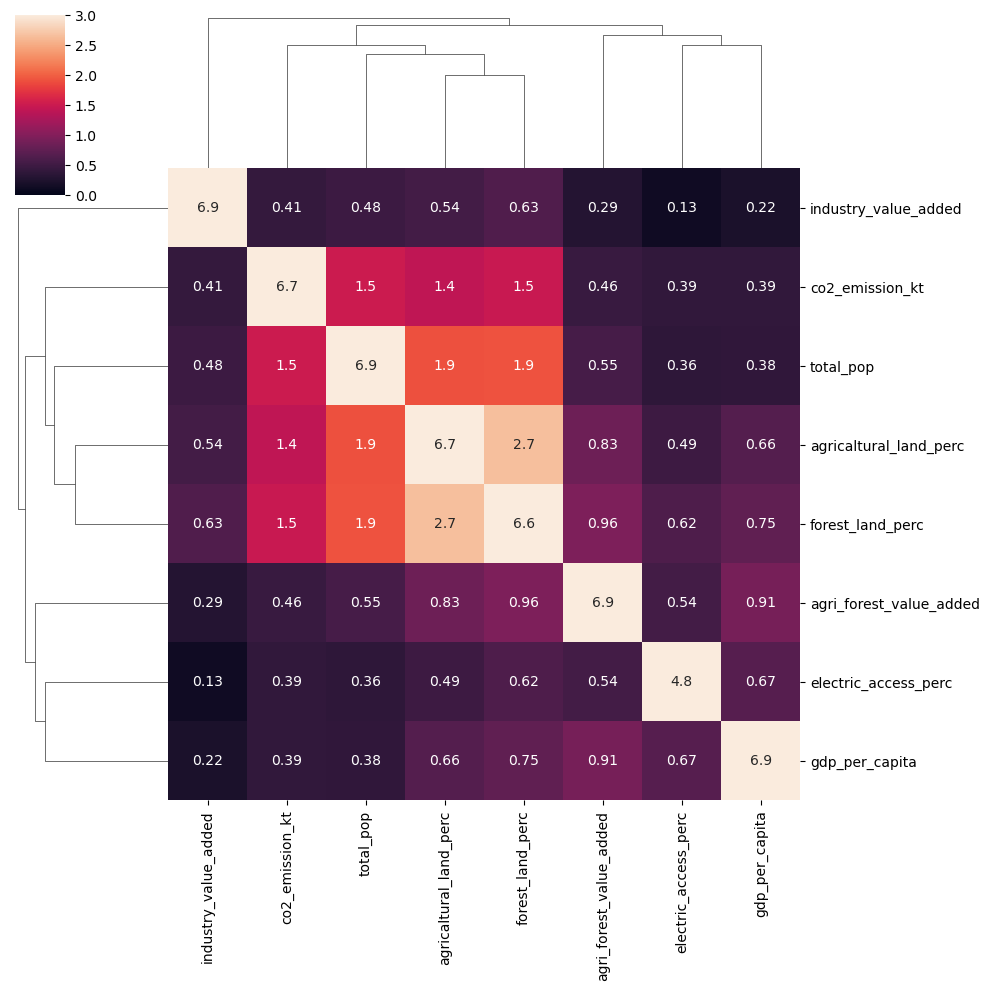

In [24]:
df = all_data_df.drop(labels=["alpha-3", "region", "data_year", "transformed_co2_emission_kt"], axis=1).dropna()
number_of_features = len(df.columns)
correlation_matrix = np.ones((number_of_features, number_of_features))

#Doğrusal ve doğrusal olmayan ilişkileri görmek için mutual_info skorelarını hiyerarşik olarak incele
for row in tqdm(range(number_of_features)):
    for col in range(number_of_features):
        if col > row: #Korelasyon matrisi simetrik olduğu için işlem sadece alt üçgen matris için yapıldı
            continue
        correlation_matrix[row][col] = mutual_info_regression(df.iloc[:, row].values.reshape(-1, 1), df.iloc[:, col].values.ravel())

#Alt üçgen matrisi üst üçgen matrise yapıştır
for row in range(number_of_features):
    for col in range(number_of_features):
        if col < row:
            continue
        correlation_matrix[row][col] = correlation_matrix[col][row]

correlation_df = pd.DataFrame(correlation_matrix, columns=df.columns, index=df.columns)
sns.clustermap(correlation_df, annot=True, vmin=0, vmax=3)
df.head()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        co2_emission_kt   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     1712.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:56:09   Log-Likelihood:                -51171.
No. Observations:                3530   AIC:                         1.024e+05
Df Residuals:                    3526   BIC:                         1.024e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1.599e+04   1.61e+04      0.995      0.320   -1.55e+04    4.75e+04
agri_forest_value_added -4691.5605    819.325     -5.726      0.000   -6297.959   -3085.163
gdp_per_capita              4.2842      0.515      8.314      0.000       3.274       5.295
total_pop                   0.0041   5.75e-05     70.697      0.000       0.004       0.004
==============================================================================
Omnibus:                     3008.143   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           449276.675
Skew:                           3.374   Prob(JB):                         0.00
Kurtosis:                      57.855   Cond. No.                     2.90e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 2000000.0, 'RMSE for predictions: 4.78e+05')

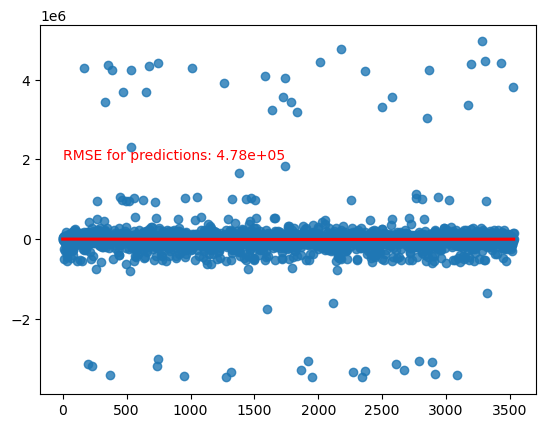

In [167]:
df = all_data_df.drop(labels=["alpha-3", "region", "data_year"], axis=1).dropna()

#'agricaltural_land_perc', 'forest_land_perc', 'electric_access_perc', 'co2_emission_kt', 'agri_forest_value_added', 'industry_value_added', 'gdp_per_capita', 'total_pop'
#industry_value_added + electric_access_perc + agricaltural_land_perc + forest_land_perc + 
mdl = smf.ols("co2_emission_kt ~ agri_forest_value_added + gdp_per_capita + total_pop", data=df).fit()
display(mdl.summary())

residuals = pd.Series(mdl.resid).sample(frac=1, replace=False).reset_index().drop(labels="index", axis=1)
ax = sns.regplot(x=residuals.index.values, y=residuals.values, lowess=True, line_kws={"color": "red"})

ax.annotate(xy=(0, 2e6), text="RMSE for predictions: {:.2e}".format(np.sqrt(mdl.mse_resid)), color="red")

In [174]:
df = all_data_df.drop(labels=["alpha-3", "region", "data_year"], axis=1).dropna()
X = df.drop(labels=["co2_emission_kt", "transformed_co2_emission_kt"], axis=1).values
y = df["co2_emission_kt"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2022)


random_forest = RandomForestRegressor(criterion="squared_error", bootstrap=True, n_jobs=-3, random_state=2022)

param_distributions = {
    "n_estimators": np.linspace(5, 500, 10).astype(np.int32),
    "max_depth": np.linspace(5, 75, 10).astype(np.int32),
    "min_samples_leaf": np.linspace(5, 350, 10).astype(np.int32),
    "max_features": np.linspace(0.1, 1, 5)
}

random_search_random_forest = RandomizedSearchCV(random_forest, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=10, n_jobs=-3, n_iter=50, verbose=3, random_state=2022)
random_search_random_forest.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 2/10] END max_depth=75, max_features=1.0, min_samples_leaf=311, n_estimators=500;, score=-311879.239 total time=   1.6s
[CV 6/10] END max_depth=75, max_features=1.0, min_samples_leaf=311, n_estimators=500;, score=-400679.678 total time=   1.7s
[CV 1/10] END max_depth=75, max_features=1.0, min_samples_leaf=311, n_estimators=500;, score=-246808.963 total time=   1.7s
[CV 3/10] END max_depth=75, max_features=1.0, min_samples_leaf=311, n_estimators=500;, score=-327439.932 total time=   1.8s
[CV 8/10] END max_depth=75, max_features=1.0, min_samples_leaf=311, n_estimators=500;, score=-312221.590 total time=   1.8s
[CV 9/10] END max_depth=75, max_features=1.0, min_samples_leaf=311, n_estimators=500;, score=-340510.193 total time=   1.8s
[CV 10/10] END max_depth=75, max_features=1.0, min_samples_leaf=311, n_estimators=500;, score=-529228.509 total time=   1.8s
[CV 4/10] END max_depth=75, max_features=1.0, min_samples_leaf=311, 

RandomizedSearchCV(cv=10,
                   estimator=RandomForestRegressor(n_jobs=-3,
                                                   random_state=2022),
                   n_iter=50, n_jobs=-3,
                   param_distributions={'max_depth': array([ 5, 12, 20, 28, 36, 43, 51, 59, 67, 75], dtype=int32),
                                        'max_features': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'min_samples_leaf': array([  5,  43,  81, 120, 158, 196, 235, 273, 311, 350], dtype=int32),
                                        'n_estimators': array([  5,  60, 115, 170, 225, 280, 335, 390, 445, 500], dtype=int32)},
                   random_state=2022, scoring='neg_mean_poisson_deviance',
                   verbose=3)

In [175]:
dt = DecisionTreeRegressor(criterion="squared_error", random_state=2022)

param_distributions = {
    "max_depth":np.linspace(5, 100, 10).astype(np.int32),
    "min_samples_split":np.linspace(15, 400, 10).astype(np.int32),
    "min_samples_leaf":np.linspace(10, 300, 10).astype(np.int32)
}

random_search_decision_tree = RandomizedSearchCV(dt, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=10, n_jobs=-3, n_iter=75, verbose=3, random_state=2022)
random_search_decision_tree.fit(X_train, y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10] END max_depth=68, min_samples_leaf=171, min_samples_split=100;, score=-193848.798 total time=   0.0s
[CV 3/10] END max_depth=68, min_samples_leaf=171, min_samples_split=100;, score=-233714.655 total time=   0.0s
[CV 4/10] END max_depth=68, min_samples_leaf=171, min_samples_split=100;, score=-170829.246 total time=   0.0s
[CV 5/10] END max_depth=68, min_samples_leaf=171, min_samples_split=100;, score=-209605.591 total time=   0.0s
[CV 6/10] END max_depth=68, min_samples_leaf=171, min_samples_split=100;, score=-269916.525 total time=   0.0s
[CV 2/10] END max_depth=68, min_samples_leaf=171, min_samples_split=100;, score=-177245.054 total time=   0.0s
[CV 8/10] END max_depth=68, min_samples_leaf=171, min_samples_split=100;, score=-201524.749 total time=   0.0s
[CV 9/10] END max_depth=68, min_samples_leaf=171, min_samples_split=100;, score=-217019.393 total time=   0.0s
[CV 7/10] END max_depth=68, min_samples_leaf=171,

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=2022),
                   n_iter=75, n_jobs=-3,
                   param_distributions={'max_depth': array([  5,  15,  26,  36,  47,  57,  68,  78,  89, 100], dtype=int32),
                                        'min_samples_leaf': array([ 10,  42,  74, 106, 138, 171, 203, 235, 267, 300], dtype=int32),
                                        'min_samples_split': array([ 15,  57, 100, 143, 186, 228, 271, 314, 357, 400], dtype=int32)},
                   random_state=2022, scoring='neg_mean_poisson_deviance',
                   verbose=3)

In [155]:
base_estimator = random_search_decision_tree.best_estimator_ #Daha önce elde ettiğimiz ideal ağacı kullandığımzda AdaBoosta ait sonucun iyileştiği görülmektedir. Decision tree için ekstra grid search yapılmamıştır.
adaboost = AdaBoostRegressor(base_estimator, random_state=2022)

param_distributions = {
    "n_estimators": np.linspace(5, 500, 10).astype(np.int32),
    "learning_rate": np.logspace(-1, 3, 10)
}

random_search_adaboost_fresh_dt = RandomizedSearchCV(adaboost, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=10, n_jobs=-3, n_iter=75, verbose=3, random_state=2022)
random_search_adaboost_fresh_dt.fit(X_train, y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-4303676.174 total time=   0.0s
[CV 5/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-20169959.923 total time=   0.0s
[CV 3/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-2871317.370 total time=   0.0s
[CV 7/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-2890488.048 total time=   0.0s
[CV 4/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-2995503.088 total time=   0.0s
[CV 6/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-3008293.338 total time=   0.0s
[CV 8/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-1648780.094 total time=   0.0s
[CV 2/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-3131468.931 total time=   0.0s
[CV 10/10] END learning_rate=129.15496650148827, n_estimators=500;, score=-980299.392 total time

RandomizedSearchCV(cv=10,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='poisson',
                                                                                    max_depth=78,
                                                                                    min_samples_leaf=10,
                                                                                    min_samples_split=57,
                                                                                    random_state=2022),
                                               random_state=2022),
                   n_iter=75, n_jobs=-3,
                   param_distributions={'learning_rate': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03]),
                                        'n_estimators': array([  5,  60, 115, 170, 225, 280, 335, 390, 445, 500], dtype=int32)},
                   random_state=2022, scoring='neg_mean_poisson_deviance',
                   verbose=3)

100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

Train Results:
Random_Forest için elde edilen R^2 değeri: 9.94e-01
Random_Forest için elde edilen RMSE değeri: 5.76e+04


Test Results:
Random_Forest için elde edilen R^2 değeri: 9.92e-01
Random_Forest için elde edilen RMSE değeri: 6.68e+04

**************************************************

Train Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 1.00e+00
Adaboost_Best_Dt için elde edilen RMSE değeri: 1.21e+04


Test Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 9.93e-01
Adaboost_Best_Dt için elde edilen RMSE değeri: 6.13e+04

**************************************************



,Random_Forest,Adaboost_Best_Dt
Split_0_Test_Score,68.18,68.36
Split_1_Test_Score,41.75,54.93
Split_2_Test_Score,63.64,47.39
Split_3_Test_Score,42.47,56.07
Split_4_Test_Score,63.61,61.86
Split_5_Test_Score,56.40,57.38
Split_6_Test_Score,75.01,61.62
Split_7_Test_Score,84.31,64.01
Split_8_Test_Score,78.06,104.77
Split_9_Test_Score,66.88,48.35


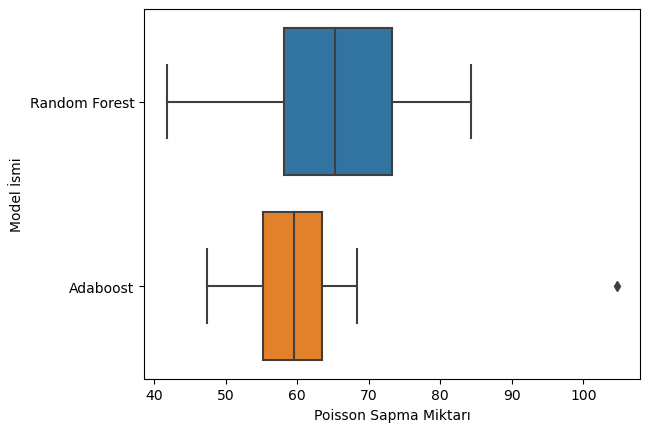

In [177]:
model_list = {
    "Random_Forest": random_search_random_forest,
    "Adaboost_Best_Dt": random_search_adaboost_fresh_dt
}

cv_results = pd.DataFrame(index=["Split_{:d}_Test_Score".format(i) for i in range(0, 10)])
coef_of_determination_test = pd.Series(dtype=np.float64)
MSE_scores_test = pd.Series(dtype=np.float64)

coef_of_determination_train = pd.Series(dtype=np.float64)
MSE_scores_train = pd.Series(dtype=np.float64)

column_range_for_cv_cols = -3 - 10

for model in tqdm(model_list.keys()):
    temp_df = pd.DataFrame(model_list[model].cv_results_).sort_values(by="rank_test_score")

    cv_results[model] = np.sqrt(np.abs(temp_df.iloc[0, column_range_for_cv_cols:-3].values).astype(np.float64))
    
    coef_of_determination_test[model] = model_list[model].best_estimator_.score(X_test, y_test)
    y_pred = model_list[model].best_estimator_.predict(X_test)
    MSE_scores_test[model] = np.sqrt(MSE(y_test, y_pred))

    coef_of_determination_train[model] = model_list[model].best_estimator_.score(X_train, y_train)
    y_pred = model_list[model].best_estimator_.predict(X_train)
    MSE_scores_train[model] = np.sqrt(MSE(y_train, y_pred))       



for model in coef_of_determination_test.index.values:
    print("Train Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_train[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_train[model]))

    print("\n")

    print("Test Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_test[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_test[model]))
    print("\n" + "*"*50 + "\n")

display(cv_results)

ax = sns.boxplot(data=cv_results.melt(), y="variable", x="value")
ax.set_xlabel("Poisson Sapma Miktarı")
ax.set_ylabel("Model İsmi")
ax.set_yticks(labels=["Random Forest", "Adaboost"], ticks=[0, 1])


In [244]:
best_model = random_search_adaboost_fresh_dt.best_estimator_
feature_list = ["Tarımsal Alan Yüzdesi", "Ormanlık Alan Yüzdesi", "Elektrik Erişimi Yüzdesi",
                "Tarım ve Orman Sektör Kazancı", "Sanayi Sektör Kazancı", "Kişi Başı GSMH",
                "Toplam Nufüs"
                ]

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   3 out of   7 | elapsed:    6.8s remaining:    9.1s
[Parallel(n_jobs=-3)]: Done   7 out of   7 | elapsed:    7.7s finished


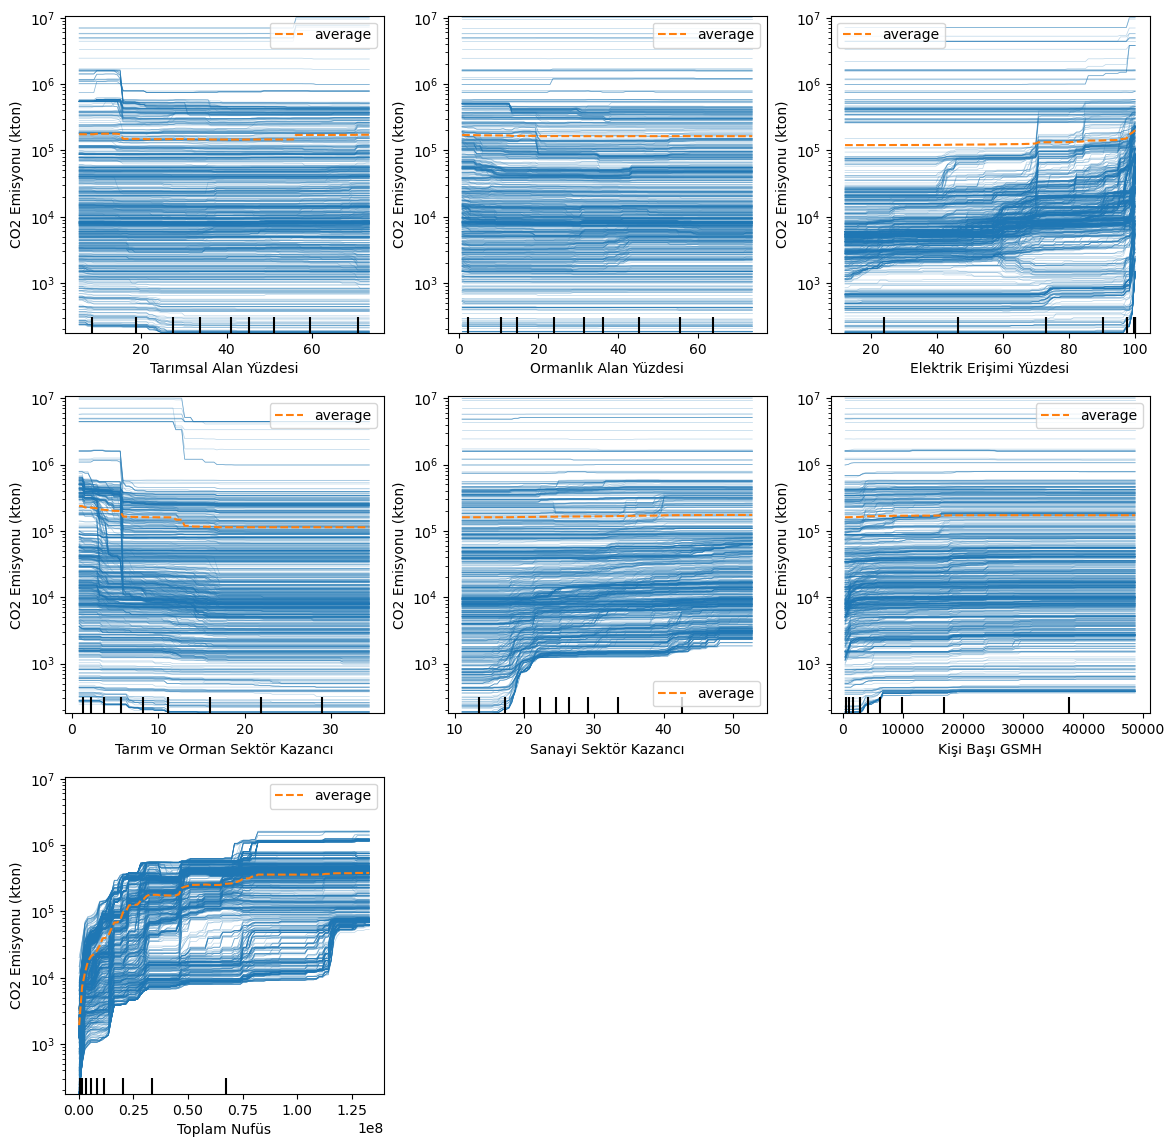

In [245]:
fig, ax = plt.subplots()
plotter = PartialDependenceDisplay.from_estimator(best_model, X_train, [i for i in range(len(feature_list))], n_jobs=-3, verbose=3, ax=ax, kind="both", random_state=2022)
for ax, feature in zip(plotter.axes_.ravel(), feature_list):
    ax.set_xlabel(feature)
    ax.set_ylabel("CO2 Emisyonu (kton)")
    ax.semilogy()      

fig.set_size_inches(14, 14)

,Feature_name,Feature_importance_mean,Feature_importance_std
1,Ormanlık Alan Yüzdesi,"324,308,477.79","49,632,121.10"
5,Kişi Başı GSMH,"395,660,524.31","34,304,667.43"
4,Sanayi Sektör Kazancı,"540,617,222.05","38,744,678.43"
2,Elektrik Erişimi Yüzdesi,"28,091,954,530.24","7,470,226,852.20"
0,Tarımsal Alan Yüzdesi,"37,750,773,848.90","6,776,633,186.70"
3,Tarım ve Orman Sektör Kazancı,"90,473,468,928.16","19,903,094,440.91"
6,Toplam Nufüs,"954,135,972,364.36","47,427,832,696.24"


Text(0.5, 0, 'Bağıl Nitelik Önemi')

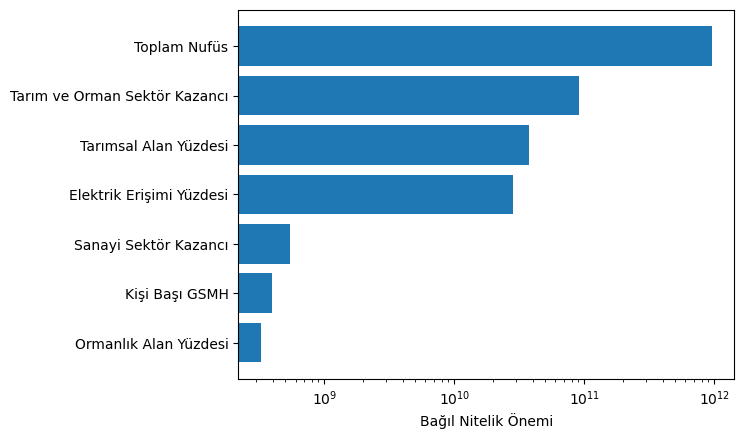

In [246]:
importance_analysis = permutation_importance(best_model, X_train, y_train, n_repeats=30, n_jobs=-3, scoring="neg_mean_squared_error", random_state=2022)

importance_analysis_df = pd.DataFrame(
{
"Feature_name": feature_list,
"Feature_importance_mean": importance_analysis.importances_mean,
"Feature_importance_std": importance_analysis.importances_std
}
).sort_values(by="Feature_importance_mean")

display(importance_analysis_df)
fig, ax = plt.subplots()
ax.barh(y=importance_analysis_df.Feature_name, width=importance_analysis_df.Feature_importance_mean)
ax.semilogx()
ax.set_xlabel("Bağıl Nitelik Önemi")

In [168]:
df.drop(labels=["co2_emission_kt", "transformed_co2_emission_kt"], axis=1).head()
#co2_emission_kt ~ agri_forest_value_added + gdp_per_capita + total_pop
#[0, 2, 3, 6]

,agricaltural_land_perc,forest_land_perc,electric_access_perc,agri_forest_value_added,industry_value_added,gdp_per_capita,total_pop
1,41.75,28.08,100.00,24.52,19.40,"1,126.68","3,089,027.00"
2,16.80,0.66,98.97,8.40,46.25,"1,765.03","31,042,238.00"
5,37.67,62.33,24.21,5.66,72.12,556.84,"16,395,477.00"
6,20.45,21.48,97.69,1.60,13.89,"10,872.29","76,007.00"
7,46.96,12.20,95.78,4.68,25.99,"7,708.10","36,870,796.00"


In [172]:
X_train_selected = X_train[:, [3, 5, 6]]
X_test_selected = X_test[:, [3, 5, 6]]

dt_selected = DecisionTreeRegressor(random_state=2022)

param_distributions = {
    "max_depth":np.linspace(2, 50, 15).astype(np.int32),
    "min_samples_leaf":np.linspace(5, 100, 15).astype(np.int32),
    "criterion": ["squared_error", "poisson", "absolute_error"]
}

random_search_decision_tree = RandomizedSearchCV(dt_selected, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=7, n_jobs=-3, n_iter=50, verbose=2, random_state=2022)
random_search_decision_tree.fit(X_train_selected, y_train)

base_estimator = random_search_decision_tree.best_estimator_ #Daha önce elde ettiğimiz ideal ağacı kullandığımzda AdaBoosta ait sonucun iyileştiği görülmektedir. Decision tree için ekstra grid search yapılmamıştır.
adaboost_selected = AdaBoostRegressor(base_estimator, random_state=2022)

param_distributions = {
    "n_estimators": np.linspace(5, 500, 15).astype(np.int32),
    "learning_rate": np.logspace(-3, 1, 30),
    "loss": ["linear", "square", "exponential"]
}

random_search_adaboost_selected = RandomizedSearchCV(adaboost_selected, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=7, n_jobs=-3, n_iter=50, verbose=2, random_state=2022)
random_search_adaboost_selected.fit(X_train_selected, y_train)

Fitting 7 folds for each of 50 candidates, totalling 350 fits
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=22, min_samples_leaf=32; total time=   0.5s
[CV] END criterion=absolute_error, max_depth=22, min_samples_leaf=32; total time=   0.5s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=poisson, max_depth=39, min_samples_leaf=32; total time=   0.0s
[CV] END criterion=poisson, max_depth=39, min_samples_leaf=32; total 

RandomizedSearchCV(cv=7,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=12,
                                                                                    min_samples_leaf=5,
                                                                                    random_state=2022),
                                               random_state=2022),
                   n_iter=50, n_jobs=-3,
                   param_distributions={'learning_rate': array([1.00000000e-03, 1.37382380e-03, 1.88739182e-03, 2.59294380e-03,
       3.56224789e-03, 4.89390092e-03, 6.72335754e-03, 9.23670857e-03,
       1.26896...
       5.73615251e-01, 7.88046282e-01, 1.08263673e+00, 1.48735211e+00,
       2.04335972e+00, 2.80721620e+00, 3.85662042e+00, 5.29831691e+00,
       7.27895384e+00, 1.00000000e+01]),
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': array([  5,  40,  75, 111, 146, 181, 217, 252, 287, 323, 358, 393, 429,
       464, 500], dtype=int32)},
                   random_state=2022, scoring='neg_mean_poisson_deviance',
                   verbose=2)

In [173]:
display(random_search_decision_tree.best_params_)
display(random_search_adaboost_selected.best_params_)

{'min_samples_leaf': 5, 'max_depth': 12, 'criterion': 'squared_error'}

{'n_estimators': 323, 'loss': 'linear', 'learning_rate': 0.11721022975334805}

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

Train Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 1.00e+00
Adaboost_Best_Dt için elde edilen RMSE değeri: 6.22e+03


Test Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 9.93e-01
Adaboost_Best_Dt için elde edilen RMSE değeri: 6.38e+04

**************************************************



,Adaboost_Best_Dt
Split_0_Test_Score,102.90
Split_1_Test_Score,100.94
Split_2_Test_Score,56.30
Split_3_Test_Score,66.56
Split_4_Test_Score,118.70
Split_5_Test_Score,85.70
Split_6_Test_Score,135.51


<AxesSubplot:xlabel='variable', ylabel='value'>

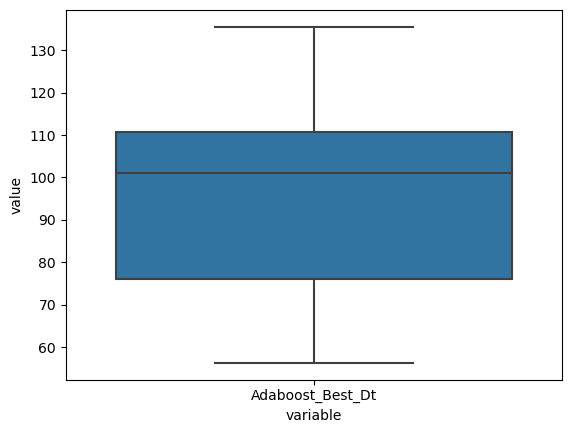

In [178]:
model_list = {
    "Adaboost_Best_Dt": random_search_adaboost_selected
}

cv_results = pd.DataFrame(index=["Split_{:d}_Test_Score".format(i) for i in range(0, 7)])
coef_of_determination_test = pd.Series(dtype=np.float64)
MSE_scores_test = pd.Series(dtype=np.float64)

coef_of_determination_train = pd.Series(dtype=np.float64)
MSE_scores_train = pd.Series(dtype=np.float64)

column_range_for_cv_cols = -3 - 7

for model in tqdm(model_list.keys()):
    temp_df = pd.DataFrame(model_list[model].cv_results_).sort_values(by="rank_test_score")

    cv_results[model] = np.sqrt(np.abs(temp_df.iloc[0, column_range_for_cv_cols:-3].values).astype(np.float64))
    
    coef_of_determination_test[model] = model_list[model].best_estimator_.score(X_test_selected, y_test)
    y_pred = model_list[model].best_estimator_.predict(X_test_selected)
    MSE_scores_test[model] = np.sqrt(MSE(y_test, y_pred))

    coef_of_determination_train[model] = model_list[model].best_estimator_.score(X_train_selected, y_train)
    y_pred = model_list[model].best_estimator_.predict(X_train_selected)
    MSE_scores_train[model] = np.sqrt(MSE(y_train, y_pred))


for model in coef_of_determination_test.index.values:
    print("Train Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_train[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_train[model]))

    print("\n")

    print("Test Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_test[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_test[model]))
    print("\n" + "*"*50 + "\n")

display(cv_results)

sns.boxplot(data=cv_results.melt(), x="variable", y="value")

'RMSE: 6.38e+04'

,Predictions,True_Values,Residuals
767,"410,687.50","1,567,170.00","1,156,482.50"
136,"7,719,069.82","8,474,919.92","755,850.10"
343,"4,415,910.16","5,124,819.82","708,909.67"
171,"5,156,430.18","5,593,029.79","436,599.61"
468,"214,250.00","630,010.01","415,760.01"
...,...,...,...
67,"294,390.01","163,149.99","-131,240.01"
642,"489,510.00","239,980.00","-249,530.01"
340,"3,810,060.06","3,529,080.00","-280,980.06"
810,"5,516,812.38","5,173,600.10","-343,212.28"


,index,Residuals
0,698,-583.59
1,584,-664.29
2,254,"12,610.00"
3,50,"83,572.84"
4,207,"4,010.72"
...,...,...
878,137,"-14,600.01"
879,271,93.85
880,512,-781.61
881,274,"-1,949.00"


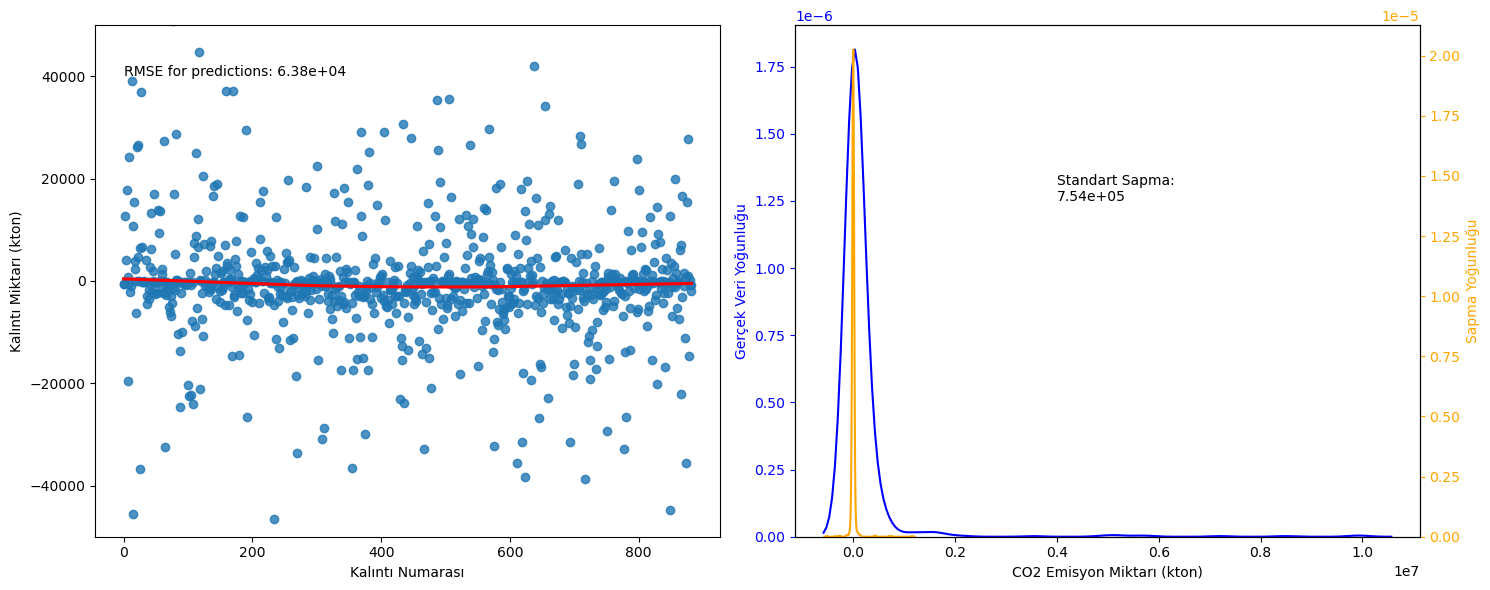

In [179]:
best_model = random_search_adaboost_selected
results = pd.DataFrame({
    "Predictions": best_model.predict(X_test_selected),
    "True_Values": y_test
})

results = results.assign(Residuals=(results.True_Values - results.Predictions))
display("RMSE: {:.2e}".format(np.sqrt(MSE(results.True_Values, results.Predictions))))
display(results.sort_values(by="Residuals", ascending=False))

residuals = results["Residuals"].sample(frac=1, replace=False).reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2)
display(residuals)
sns.regplot(x=residuals.index.values, y=residuals.Residuals.values, lowess=True, line_kws={"color": "red"}, ax=ax[0])
ax[0].annotate(xy=(0, 4e4), text="RMSE for predictions: {:.2e}".format(np.sqrt(MSE(results.True_Values, results.Predictions))), color="black")
ax[0].set_ylim(-5e4, 5e4)
ax[0].set_xlabel("Kalıntı Numarası")
ax[0].set_ylabel("Kalıntı Miktarı (kton)")

ax1_rep = ax[1].twinx()
sns.kdeplot(data=results, x="True_Values", ax=ax[1], color="blue", label="Gerçek Veri")
ax[1].annotate(xy=(0.4e7, 1.25e-6), text="Standart Sapma:\n{:.2e}".format(np.std(results.True_Values)), color="black")
ax[1].set_xlabel("CO2 Emisyon Miktarı (kton)")
ax[1].set_ylabel("Gerçek Veri Yoğunluğu", color="blue")
ax[1].tick_params(axis="y", color="blue", labelcolor="blue")

sns.kdeplot(data=results, x="Residuals", ax=ax1_rep, label="Kalıntı Miktarı", color="orange")
ax1_rep.set_ylabel("Sapma Yoğunluğu", color="orange")
ax1_rep.tick_params(axis="y", color="orange", labelcolor="orange")



fig.set_size_inches(15, 6)
fig.tight_layout()

In [181]:
X_train_selected = X_train[:, [0, 2, 3, 6]]
X_test_selected = X_test[:, [0, 2, 3, 6]]

dt_selected = DecisionTreeRegressor(random_state=2022)

param_distributions = {
    "max_depth":np.linspace(2, 50, 15).astype(np.int32),
    "min_samples_leaf":np.linspace(5, 100, 15).astype(np.int32),
    "criterion": ["squared_error", "poisson", "absolute_error"]
}

random_search_decision_tree = RandomizedSearchCV(dt_selected, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=7, n_jobs=-3, n_iter=50, verbose=2, random_state=2022)
random_search_decision_tree.fit(X_train_selected, y_train)

base_estimator = random_search_decision_tree.best_estimator_ #Daha önce elde ettiğimiz ideal ağacı kullandığımzda AdaBoosta ait sonucun iyileştiği görülmektedir. Decision tree için ekstra grid search yapılmamıştır.
adaboost_selected = AdaBoostRegressor(base_estimator, random_state=2022)

param_distributions = {
    "n_estimators": np.linspace(5, 500, 15).astype(np.int32),
    "learning_rate": np.logspace(-3, 1, 30),
    "loss": ["linear", "square", "exponential"]
}

random_search_adaboost_selected = RandomizedSearchCV(adaboost_selected, param_distributions=param_distributions, scoring="neg_mean_poisson_deviance", cv=7, n_jobs=-3, n_iter=50, verbose=2, random_state=2022)
random_search_adaboost_selected.fit(X_train_selected, y_train)

Fitting 7 folds for each of 50 candidates, totalling 350 fits
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=18; total time=   0.0s
[CV] END criterion=poisson, max_depth=39, min_samples_leaf=32; total time=   0.0s
[CV] END criterion=poisson, max_depth=39, min_samples_leaf=32; total time=   0.0s
[CV] END criterion=poisson, max_depth=39, min_samples_leaf=32; total time=   0.0s
[CV] END criterion=poisson, max_depth=39, min_samples_leaf=32; total time=   0.0s
[

RandomizedSearchCV(cv=7,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                                                    max_depth=22,
                                                                                    min_samples_leaf=5,
                                                                                    random_state=2022),
                                               random_state=2022),
                   n_iter=50, n_jobs=-3,
                   param_distributions={'learning_rate': array([1.00000000e-03, 1.37382380e-03, 1.88739182e-03, 2.59294380e-03,
       3.56224789e-03, 4.89390092e-03, 6.72335754...
       5.73615251e-01, 7.88046282e-01, 1.08263673e+00, 1.48735211e+00,
       2.04335972e+00, 2.80721620e+00, 3.85662042e+00, 5.29831691e+00,
       7.27895384e+00, 1.00000000e+01]),
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': array([  5,  40,  75, 111, 146, 181, 217, 252, 287, 323, 358, 393, 429,
       464, 500], dtype=int32)},
                   random_state=2022, scoring='neg_mean_poisson_deviance',
                   verbose=2)

100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

Train Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 1.00e+00
Adaboost_Best_Dt için elde edilen RMSE değeri: 2.03e+03


Test Results:
Adaboost_Best_Dt için elde edilen R^2 değeri: 9.96e-01
Adaboost_Best_Dt için elde edilen RMSE değeri: 4.61e+04

**************************************************



,Adaboost_Best_Dt
Split_0_Test_Score,49.17
Split_1_Test_Score,29.35
Split_2_Test_Score,62.41
Split_3_Test_Score,46.28
Split_4_Test_Score,49.70
Split_5_Test_Score,42.89
Split_6_Test_Score,28.38


<AxesSubplot:xlabel='variable', ylabel='value'>

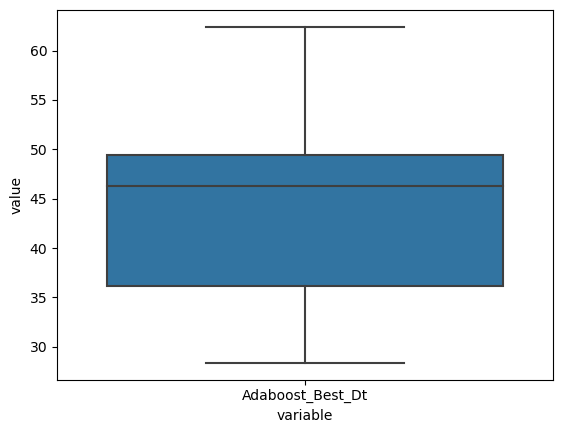

In [182]:
model_list = {
    "Adaboost_Best_Dt": random_search_adaboost_selected
}

cv_results = pd.DataFrame(index=["Split_{:d}_Test_Score".format(i) for i in range(0, 7)])
coef_of_determination_test = pd.Series(dtype=np.float64)
MSE_scores_test = pd.Series(dtype=np.float64)

coef_of_determination_train = pd.Series(dtype=np.float64)
MSE_scores_train = pd.Series(dtype=np.float64)

column_range_for_cv_cols = -3 - 7

for model in tqdm(model_list.keys()):
    temp_df = pd.DataFrame(model_list[model].cv_results_).sort_values(by="rank_test_score")

    cv_results[model] = np.sqrt(np.abs(temp_df.iloc[0, column_range_for_cv_cols:-3].values).astype(np.float64))
    
    coef_of_determination_test[model] = model_list[model].best_estimator_.score(X_test_selected, y_test)
    y_pred = model_list[model].best_estimator_.predict(X_test_selected)
    MSE_scores_test[model] = np.sqrt(MSE(y_test, y_pred))

    coef_of_determination_train[model] = model_list[model].best_estimator_.score(X_train_selected, y_train)
    y_pred = model_list[model].best_estimator_.predict(X_train_selected)
    MSE_scores_train[model] = np.sqrt(MSE(y_train, y_pred))


for model in coef_of_determination_test.index.values:
    print("Train Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_train[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_train[model]))

    print("\n")

    print("Test Results:")
    print("{:s} için elde edilen R^2 değeri: {:.2e}".format(model, coef_of_determination_test[model]))
    print("{:s} için elde edilen RMSE değeri: {:.2e}".format(model, MSE_scores_test[model]))
    print("\n" + "*"*50 + "\n")

display(cv_results)

sns.boxplot(data=cv_results.melt(), x="variable", y="value")

'RMSE: 4.61e+04'

,Predictions,True_Values,Residuals
136,"7,719,069.82","8,474,919.92","755,850.10"
343,"4,415,910.16","5,124,819.82","708,909.67"
474,"9,541,870.12","9,984,570.31","442,700.20"
740,"1,972,430.05","2,147,110.11","174,680.05"
44,"1,100,979.98","1,225,069.95","124,089.97"
...,...,...,...
642,"379,989.99","239,980.00","-140,009.99"
387,"1,564,880.00","1,424,380.00","-140,500.00"
703,"10,006,669.92","9,861,099.61","-145,570.31"
340,"3,810,060.06","3,529,080.00","-280,980.06"


,index,Residuals
0,85,"-12,110.00"
1,245,"3,115.00"
2,346,-870.00
3,432,"5,810.00"
4,244,"-2,320.00"
...,...,...
878,264,"13,900.00"
879,243,"-3,180.00"
880,687,"43,079.96"
881,428,520.00


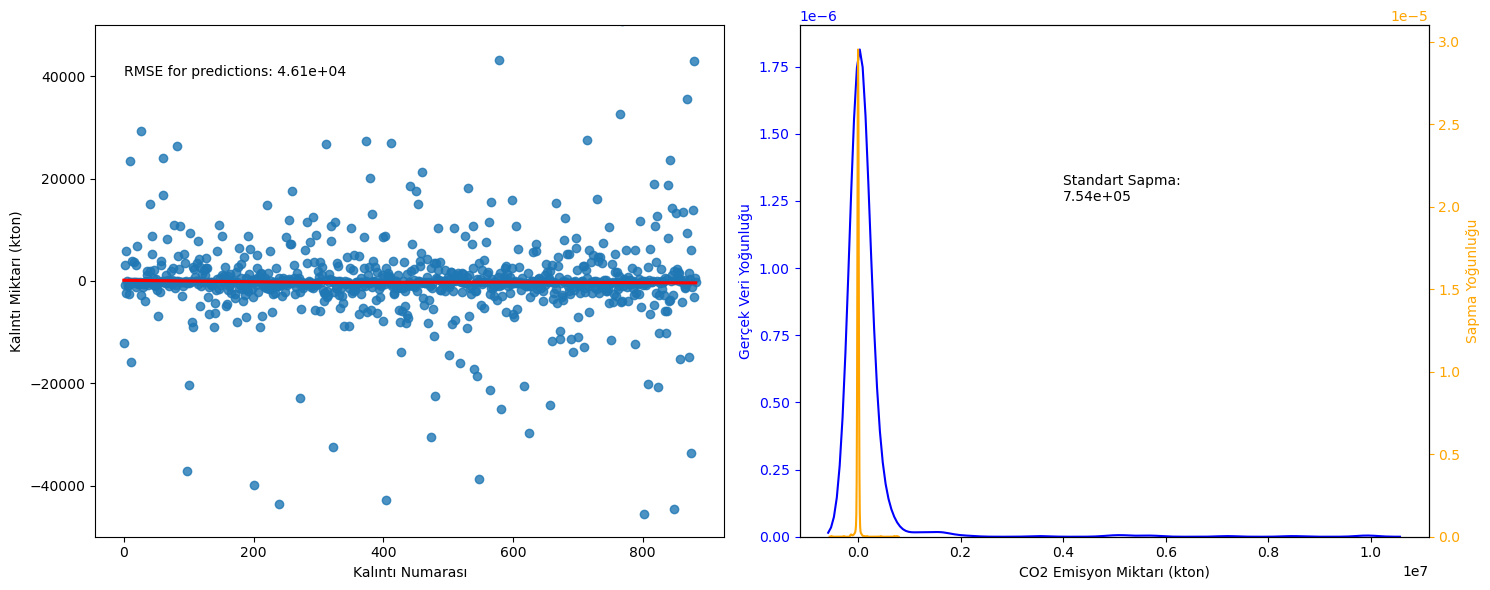

In [184]:
best_model = random_search_adaboost_selected
results = pd.DataFrame({
    "Predictions": best_model.predict(X_test_selected),
    "True_Values": y_test
})

results = results.assign(Residuals=(results.True_Values - results.Predictions))
display("RMSE: {:.2e}".format(np.sqrt(MSE(results.True_Values, results.Predictions))))
display(results.sort_values(by="Residuals", ascending=False))

residuals = results["Residuals"].sample(frac=1, replace=False).reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2)
display(residuals)
sns.regplot(x=residuals.index.values, y=residuals.Residuals.values, lowess=True, line_kws={"color": "red"}, ax=ax[0])
ax[0].annotate(xy=(0, 4e4), text="RMSE for predictions: {:.2e}".format(np.sqrt(MSE(results.True_Values, results.Predictions))), color="black")
ax[0].set_ylim(-5e4, 5e4)
ax[0].set_xlabel("Kalıntı Numarası")
ax[0].set_ylabel("Kalıntı Miktarı (kton)")

ax1_rep = ax[1].twinx()
sns.kdeplot(data=results, x="True_Values", ax=ax[1], color="blue", label="Gerçek Veri")
ax[1].annotate(xy=(0.4e7, 1.25e-6), text="Standart Sapma:\n{:.2e}".format(np.std(results.True_Values)), color="black")
ax[1].set_xlabel("CO2 Emisyon Miktarı (kton)")
ax[1].set_ylabel("Gerçek Veri Yoğunluğu", color="blue")
ax[1].tick_params(axis="y", color="blue", labelcolor="blue")

sns.kdeplot(data=results, x="Residuals", ax=ax1_rep, label="Kalıntı Miktarı", color="orange")
ax1_rep.set_ylabel("Sapma Yoğunluğu", color="orange")
ax1_rep.tick_params(axis="y", color="orange", labelcolor="orange")



fig.set_size_inches(15, 6)
fig.tight_layout()